# Data analysis and visualisation of the rhizotron scale

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates

In [2]:
sheet_id = '1GqDKU8fC0Pw_DQpUD-MBLpN-AXWrAzLuO1hABxxYIhc'
sheet_name = ['apr_6-11','apr_11-13','apr_13-21','apr_21-26','apr_28-may_2']
sheet_nb = 5
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name[sheet_nb-1]}'
data_scale = pd.read_csv(url, decimal=',')

In [3]:
# add absolute date collumn

data_scale['abs_date'] = pd.to_datetime(data_scale['date'] + " " + data_scale['time'],
                                        infer_datetime_format=True)  

#data_scale['abs_date2'] = pd.to_datetime(data_scale['abs_date'],
#                                        format="%Y-%m-%d %H:%M:%S")  

#data_scale = data_scale.set_index('abs_date')
initial_date = data_scale['abs_date'][0]


In [4]:
#data_scale = pd.read_csv('evapo_test4.csv',header=None,names=['weight','time'])
#data_scale
#initial_date = pd.Timestamp('2022-03-02 16:00:00')
initial_date = data_scale['abs_date'][0]
dates = []
for i in range(len(data_scale['time'])):
    dates.append(initial_date + pd.Timedelta(seconds=data_scale['sec'][i]))
date_time = [t.strftime("%Y-%m-%d %H:%M:%S") for t in dates]
data_scale['abs_date_new']=date_time
data_scale['abs_date_new']= pd.to_datetime(data_scale['abs_date_new'])
#data_scale.dtypes


## Plot raw data

[Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'weight (kg)'),
 Text(0.5, 1.0, 'Raw data sheet apr_28-may_2')]

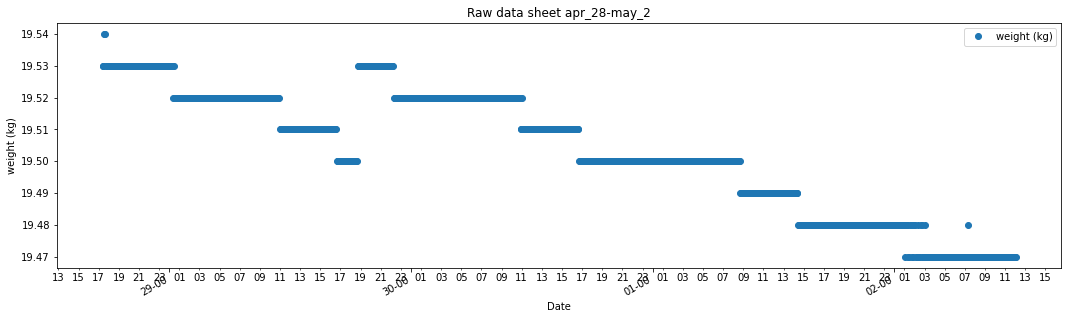

In [5]:
fig, ax = plt.subplots(figsize=(18, 5))

data_scale.plot('abs_date_new', 'weight (kg)', style='o', ax=ax)

ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=2))

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%H'))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))


# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="weight (kg)",
       title="Raw data sheet " + sheet_name[sheet_nb-1])



## Data processing and computation of relevant values

In [20]:
data_scale['cumweight'] = data_scale['weight (kg)'].cumsum()
#data_scale['rolling'] = data_scale['weight (kg)'].rolling(20).sum()
data_scale['rolling'] = data_scale['weight (kg)'].rolling(12).mean()

data_scale['rolling_std'] = data_scale['weight (kg)'].rolling(12).std()
data_scale['diff'] = data_scale['rolling'].diff()

In [21]:
diurn=[]
for d in data_scale['abs_date_new']:
    #print(d)
    #print(int(d.strftime('%H')))
    if int(d.strftime('%H'))>=7 and int(d.strftime('%H'))<=19:
        diurn.append(True)
    else:
        diurn.append(False)

data_scale['diurn'] = diurn  

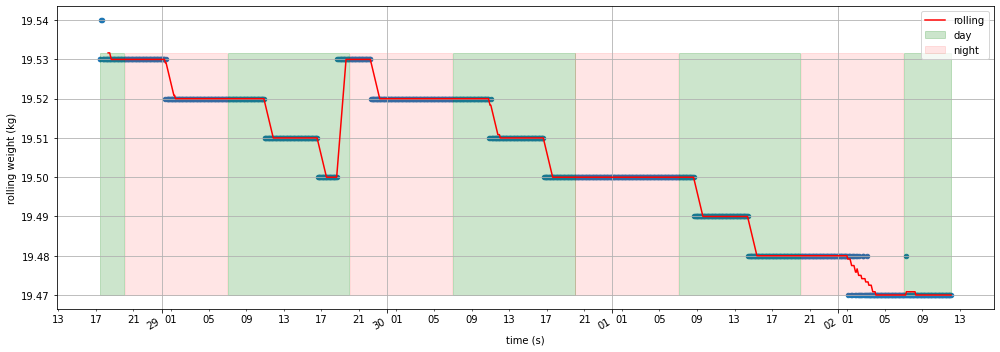

In [22]:
fig, ax = plt.subplots(figsize=(14, 5))

data_scale.plot.scatter(x='abs_date_new',y='weight (kg)', ax=ax)
data_scale.plot(x='abs_date_new',y='rolling', ax=ax, color='r')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=4))

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))

plt.gcf().autofmt_xdate()
ax.fill_between(data_scale['abs_date_new'], data_scale['rolling'].min(), data_scale['rolling'].max(), where=data_scale['diurn']==True,
                color='green', alpha=0.2, label='day')
ax.fill_between(data_scale['abs_date_new'], data_scale['rolling'].min(), data_scale['rolling'].max(), where=data_scale['diurn']==False,
                color='red', alpha=0.1, label='night')
plt.xlabel('time (s)')
plt.ylabel('rolling weight (kg)')
plt.legend()
plt.grid()
plt.tight_layout()

plt.show()
fig.savefig(sheet_name[sheet_nb-1]+'.png', 
            dpi=450,
            transparent=False)


## Potential ET evaluation

In [9]:
date0 = data_scale['abs_date_new'][0]
date1 = data_scale['abs_date_new'].iloc[-1]
delta = date1 - date0

mask = (data_scale['abs_date_new'] > date0) & (data_scale['abs_date_new'] <= date1)
weight_lost = data_scale['weight (kg)'].loc[mask]

rhizo_surface_m2 = 0.03*0.5

data_scale['ET_sec'] = (weight_lost/delta.total_seconds())*rhizo_surface_m2
data_scale['ET_h'] =  (weight_lost/round(delta.total_seconds()/60))*rhizo_surface_m2

data_scale_ET_sec = ((weight_lost.max() - weight_lost.min())/delta.total_seconds())*rhizo_surface_m2


In [10]:
data_scale_ET_sec

3.216941332181375e-09

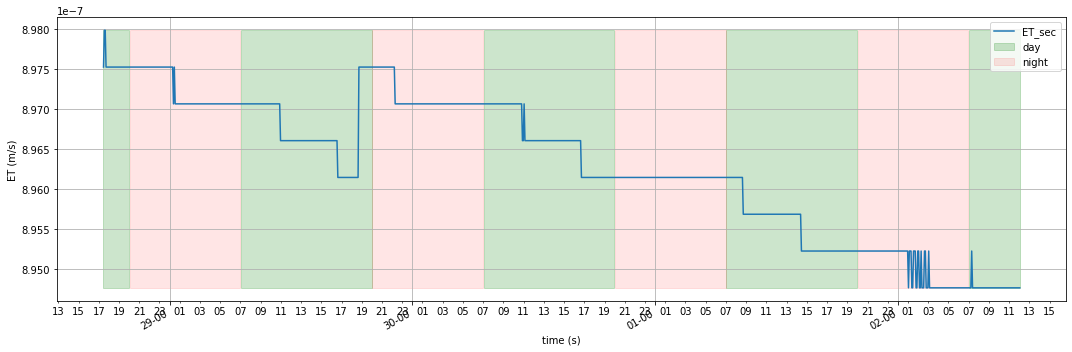

In [11]:
fig, ax = plt.subplots(figsize=(15, 5))
data_scale.plot(x='abs_date_new',y='ET_sec', ax=ax)

ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=2))

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%H'))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))

plt.gcf().autofmt_xdate()
ax.fill_between(data_scale['abs_date_new'], data_scale['ET_sec'].min(), 
                data_scale['ET_sec'].max(), 
                where=data_scale['diurn']==True,
                color='green', alpha=0.2, label='day')
ax.fill_between(data_scale['abs_date_new'], data_scale['ET_sec'].min(), 
                data_scale['ET_sec'].max(), 
                where=data_scale['diurn']==False,
                color='red', alpha=0.1, label='night')
plt.xlabel('time (s)')
plt.ylabel('ET (m/s)')
plt.legend()
plt.grid()
plt.tight_layout()
fig.savefig(sheet_name[sheet_nb-1]+'_ET.png', dpi=450)
plt.show()

### Bibliography

## TO-DO
- Normalise lost of weight by the leaf surface area measured at the end of the 30d growth period (see Garrigues et al., (2006)); + Technical Note: A Device to Directly Measure Transpiration from Vegetation Grown in Containers


#### Testing

## ax = data_scale.plot(x='abs_date_new',y='rolling_std')
ax.xaxis.set_major_locator(mdates.HourLocator(interval=8))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%H'))
plt.gcf().autofmt_xdate()
plt.xlabel('time (s)')
plt.ylabel('rolling_std weight (kg)')
plt.grid()
plt.show()